### Imports and functions

In [68]:
import gzip
from collections import defaultdict
import math
import numpy as np
import pandas as pd
import string
import random
import string
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as MSE
import json
import dateutil
import time
import warnings
warnings.filterwarnings("ignore")

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textwrap import wrap
from nltk.stem import WordNetLemmatizer
from nltk.corpus  import stopwords
import re

In [73]:
data = []
ratingsTime = []
f = gzip.open('renttherunway_final_data.json.gz', 'r')
for l in f:
    try:
        x = eval(l)
        
        # Data cleaning: convert height, weight, and rating to integer types
        x['rating'] = int(x['rating'])

        t = dateutil.parser.parse(x['review_date'])
        ratingsTime.append((t,x['rating']))

        if 'age' in x:
            x['age'] = int(x['age'])
        if 'weight' in x:
            x['weight'] = int(x['weight'][:-3])
        if 'height' in x:
            feet = int(x['height'][0])
            inches = int(x['height'][-3:-1].strip(" "))
            x['height'] = (feet * 12) + inches

        data.append(x)
    except NameError:
        continue
for l in f:
    try:
        x = eval(l)
        data.append(x)
    except NameError:
        continue

In [74]:
data[0]

{'fit': 'fit',
 'user_id': '420272',
 'bust size': '34d',
 'item_id': '2260466',
 'weight': 137,
 'rating': 10,
 'rented for': 'vacation',
 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
 'body type': 'hourglass',
 'review_summary': 'So many compliments!',
 'category': 'romper',
 'height': 68,
 'size': 14,
 'age': 28,
 'review_date': 'April 20, 2016'}

### Dataframe

In [209]:
df = pd.DataFrame(data)
df['review_date']  = pd.to_datetime(df['review_date'])
df.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137.0,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,68.0,14,28.0,2016-04-20
1,fit,273551,34b,153475,132.0,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,66.0,12,36.0,2013-06-18
2,fit,360448,NaN,1063761,NaN,10,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,64.0,4,116.0,2015-12-14
3,fit,909926,34c,126335,135.0,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,65.0,8,34.0,2014-02-12
4,fit,151944,34b,616682,145.0,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,69.0,12,27.0,2016-09-26


### Describing data

In [36]:
df.describe()

,weight,rating,height,size,age
count,162505.000000,192462.000000,191785.000000,192462.000000,191503.000000
mean,137.393649,9.092371,65.310707,12.245254,33.869955
std,21.901410,1.430044,2.663612,8.495463,8.057671
min,50.000000,2.000000,54.000000,0.000000,0.000000
25%,123.000000,8.000000,63.000000,8.000000,29.000000
50%,135.000000,10.000000,65.000000,12.000000,32.000000
75%,148.000000,10.000000,67.000000,16.000000,37.000000
max,300.000000,10.000000,78.000000,58.000000,117.000000


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192462 entries, 0 to 192461
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   fit             192462 non-null  object        
 1   user_id         192462 non-null  object        
 2   bust size       174065 non-null  object        
 3   item_id         192462 non-null  object        
 4   weight          162505 non-null  float64       
 5   rating          192462 non-null  int64         
 6   rented for      192452 non-null  object        
 7   review_text     192462 non-null  object        
 8   body type       177825 non-null  object        
 9   review_summary  192462 non-null  object        
 10  category        192462 non-null  object        
 11  height          191785 non-null  float64       
 12  size            192462 non-null  int64         
 13  age             191503 non-null  float64       
 14  review_date     192462 non-null  dat

In [95]:
df.dtypes

fit                       object
user_id                   object
bust size                 object
item_id                   object
weight                   float64
rating                     int64
rented for                object
review_text               object
body type                 object
review_summary            object
category                  object
height                   float64
size                       int64
age                      float64
review_date       datetime64[ns]
dtype: object

In [210]:
df.shape

(192462, 15)

### WordCloud

In [142]:
def cleaning(df1):
    lowered=df1.lower() # lowering the sentences 
    removed=re.sub(r'[^a-z]',' ',lowered)  # replacing the non alphabets with space 
    splitted=removed.split(' ')   # splitting the sentences by spaces to lemmatize
    df1= [WordNetLemmatizer().lemmatize(word) for word in splitted if word not in stopwords.words('english')]  # lemmatizing and removing stopwords
    df1=' '.join(df1) # joining back the words of list
    return(removed)

In [107]:
df['review_text'] = df['review_text'].apply(cleaning)
df.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137.0,10,vacation,an adorable romper belt and zipper were a lit...,hourglass,So many compliments!,romper,68.0,14,28.0,2016-04-20
1,fit,273551,34b,153475,132.0,10,other,i rented this dress for a photo shoot the the...,straight & narrow,I felt so glamourous!!!,gown,66.0,12,36.0,2013-06-18
2,fit,360448,NaN,1063761,NaN,10,party,this hugged in all the right places it was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,64.0,4,116.0,2015-12-14
3,fit,909926,34c,126335,135.0,8,formal affair,i rented this for my company s black tie award...,pear,Dress arrived on time and in perfect condition.,dress,65.0,8,34.0,2014-02-12
4,fit,151944,34b,616682,145.0,10,wedding,i have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,69.0,12,27.0,2016-09-26


In [111]:
corpus=' '.join(df['review_text'])

In [114]:
word_cloud=WordCloud(background_color="white").generate(corpus)
word_cloud

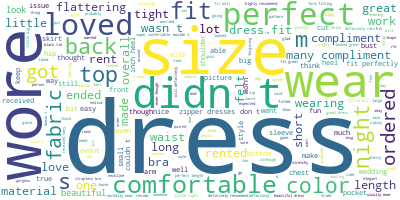

In [115]:
img = word_cloud.to_image()
img

### Fit and rating

In [140]:
df['fit'].value_counts(normalize=True)

fit      0.737782
small    0.133928
large    0.128290
Name: fit, dtype: float64

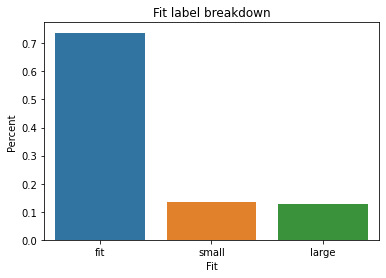

In [141]:
ax = sns.barplot(x = df['fit'].value_counts(normalize=True).index, y = df['fit'].value_counts(normalize=True), 
              data = df)
ax.set(xlabel='Fit', ylabel='Percent', title='Fit label breakdown')
plt.show()

In [31]:
df.groupby('fit')['rating'].mean()

fit
fit      9.308469
large    8.551942
small    8.419615
Name: rating, dtype: float64

In [32]:
df.groupby('fit')['rating'].median()

fit
fit      10
large     8
small     8
Name: rating, dtype: int64

We see that people tend to rate lower when clothes doesn't fit them, which is to be expected.
We will use the fit column as one of our features to predict ratings.
Since the label is imbalanced, we may not see too much improvement in our model but we will give it a try.

### Temporal analysis

Next, we will do some temporal analysis to check if time is a good predictor for rating.

In [84]:
df.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137.0,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,68.0,14,28.0,2016-04-20
1,fit,273551,34b,153475,132.0,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,66.0,12,36.0,2013-06-18
2,fit,360448,NaN,1063761,NaN,10,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,64.0,4,116.0,2015-12-14
3,fit,909926,34c,126335,135.0,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,65.0,8,34.0,2014-02-12
4,fit,151944,34b,616682,145.0,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,69.0,12,27.0,2016-09-26


In [57]:
temporal = df.copy()
temporal['day'] = df['review_date'].dt.day_name()
temporal.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date,day
0,fit,420272,34d,2260466,137.0,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,68.0,14,28.0,2016-04-20,Wednesday
1,fit,273551,34b,153475,132.0,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,66.0,12,36.0,2013-06-18,Tuesday
2,fit,360448,NaN,1063761,NaN,10,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,64.0,4,116.0,2015-12-14,Monday
3,fit,909926,34c,126335,135.0,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,65.0,8,34.0,2014-02-12,Wednesday
4,fit,151944,34b,616682,145.0,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,69.0,12,27.0,2016-09-26,Monday


In [147]:
ser = temporal.groupby('day')['rating'].mean()
ser

day
Friday       9.017958
Monday       9.099228
Saturday     9.095494
Sunday       9.162384
Thursday     9.077774
Tuesday      9.101494
Wednesday    9.084604
Name: rating, dtype: float64

In [211]:
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ordered = ser.reindex(cats)
ordered

day
Monday       9.099228
Tuesday      9.101494
Wednesday    9.084604
Thursday     9.077774
Friday       9.017958
Saturday     9.095494
Sunday       9.162384
Name: rating, dtype: float64

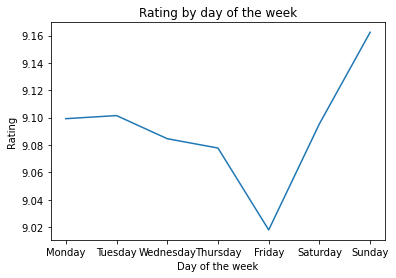

In [162]:
ax = sns.lineplot(data=ordered)
ax.set(xlabel='Day of the week', ylabel='Rating', title='Rating by day of the week')
plt.show()

#### Sliding window for temporal analysis

In [185]:
ratingsTime.sort()
len(ratingsTime)

192462

In [198]:
# ratingsTime = ratingsTime[8500:] after ~2016

In [199]:
len(ratingsTime)

111962

In [200]:
ratingsTime[:5]

[(datetime.datetime(2016, 3, 10, 0, 0), 10),
 (datetime.datetime(2016, 3, 10, 0, 0), 10),
 (datetime.datetime(2016, 3, 10, 0, 0), 10),
 (datetime.datetime(2016, 3, 10, 0, 0), 10),
 (datetime.datetime(2016, 3, 10, 0, 0), 10)]

In [201]:
wSize = 1000
x = [r[0] for r in ratingsTime] # as raw times
y = [r[1] for r in ratingsTime] # ratings
xu = [time.mktime(d.timetuple()) for d in x] # as unix times

In [202]:
xSum = sum(xu[:wSize])
ySum = sum(y[:wSize])
sliding = []

In [203]:
for i in range(wSize,len(x)-1):
    xSum += xu[i] - xu[i-wSize]
    ySum += y[i] - y[i-wSize]
    sliding.append((xSum*1.0/wSize,ySum*1.0/wSize))

In [204]:
X = [a[0] for a in sliding]
Y = [a[1] for a in sliding]

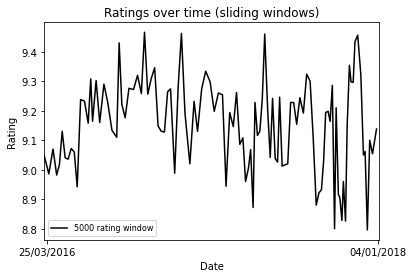

In [206]:
plt.plot(X[::1000],Y[::1000], label="5000 rating window", color='k')
plt.xticks([X[600], X[-350]], [x[wSize+600].strftime("%d/%m/%Y"), x[-350].strftime("%d/%m/%Y")])
plt.xlim(X[0], X[-1])
plt.ylabel("Rating")
plt.xlabel("Date")
plt.legend(loc="best",fontsize=8)
plt.title("Ratings over time (sliding windows)")
plt.show()

### Hourglass EDA

In [213]:
df

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137.0,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,68.0,14,28.0,2016-04-20
1,fit,273551,34b,153475,132.0,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,66.0,12,36.0,2013-06-18
2,fit,360448,NaN,1063761,NaN,10,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,64.0,4,116.0,2015-12-14
3,fit,909926,34c,126335,135.0,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,65.0,8,34.0,2014-02-12
4,fit,151944,34b,616682,145.0,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,69.0,12,27.0,2016-09-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192457,fit,66386,34dd,2252812,140.0,10,work,Fit like a glove!,hourglass,LOVE IT!!! First Item Im thinking of buying!,jumpsuit,69.0,8,42.0,2016-05-18
192458,fit,118398,32c,682043,100.0,10,work,The pattern contrast on this dress is really s...,petite,LOVE it!,dress,61.0,4,29.0,2016-09-30
192459,fit,47002,36a,683251,135.0,6,everyday,"Like the other DVF wraps, the fit on this is f...",straight & narrow,"Loud patterning, flattering fit",dress,68.0,8,31.0,2016-03-04
192460,fit,961120,36c,126335,165.0,10,wedding,This dress was PERFECTION. it looked incredib...,pear,loved this dress it was comfortable and photog...,dress,66.0,16,31.0,2015-11-25


In [ ]:
sns.barplot(data=df, x="island", y="body_mass_g")

In [ ]:
grouped = df.groupby(['body_type', 'fit']).agg(mean=())

In [280]:
hrglass_mean = df.groupby(['body type', 'fit']).count() / df.groupby(['body type']).count().drop(columns=['fit'])
hrglass_mean = hrglass_mean.reset_index()
hrglass_mean

,body type,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,review_summary,category,height,size,age,review_date
0,apple,fit,0.714989,0.714982,0.714989,0.711211,0.714989,0.714989,0.714989,0.714989,0.714989,0.714932,0.714989,0.714991,0.714989
1,apple,large,0.136354,0.135195,0.136354,0.134384,0.136354,0.136354,0.136354,0.136354,0.136354,0.136364,0.136354,0.136747,0.136354
2,apple,small,0.148657,0.149823,0.148657,0.154404,0.148657,0.148657,0.148657,0.148657,0.148657,0.148704,0.148657,0.148262,0.148657
3,athletic,fit,0.743242,0.743114,0.743242,0.743536,0.743242,0.743230,0.743242,0.743242,0.743242,0.743256,0.743242,0.743481,0.743242
4,athletic,large,0.120224,0.120270,0.120224,0.120737,0.120224,0.120229,0.120224,0.120224,0.120224,0.120238,0.120224,0.119938,0.120224
5,athletic,small,0.136534,0.136615,0.136534,0.135727,0.136534,0.136541,0.136534,0.136534,0.136534,0.136506,0.136534,0.136581,0.136534
6,full bust,fit,0.717981,0.714720,0.717981,0.713452,0.717981,0.717962,0.717981,0.717981,0.717981,0.717672,0.717981,0.718182,0.717981
7,full bust,large,0.139476,0.141566,0.139476,0.139497,0.139476,0.139485,0.139476,0.139476,0.139476,0.139222,0.139476,0.139572,0.139476
8,full bust,small,0.142543,0.143714,0.142543,0.147051,0.142543,0.142552,0.142543,0.142543,0.142543,0.143106,0.142543,0.142246,0.142543
9,hourglass,fit,0.738103,0.738370,0.738103,0.736915,0.738103,0.738098,0.738103,0.738103,0.738103,0.738300,0.738103,0.738015,0.738103


[Text(0.5, 0, 'Body type'),
 Text(0, 0.5, 'Proportion'),
 Text(0.5, 1.0, 'Proportion by body type based on fit')]

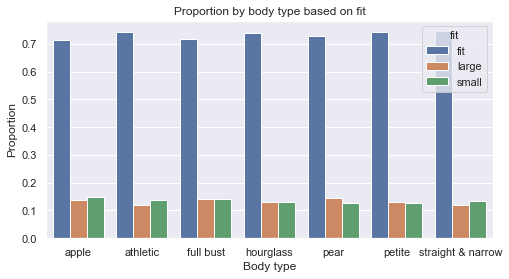

In [282]:
ax = sns.barplot(x = 'body type', y='user_id', hue='fit', data=hrglass_mean)
sns.set(rc={'figure.figsize':(8,4)})
ax.set(xlabel='Body type', ylabel='Proportion', title='Proportion by body type based on fit')

In [283]:
df

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137.0,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,68.0,14,28.0,2016-04-20
1,fit,273551,34b,153475,132.0,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,66.0,12,36.0,2013-06-18
2,fit,360448,NaN,1063761,NaN,10,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,64.0,4,116.0,2015-12-14
3,fit,909926,34c,126335,135.0,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,65.0,8,34.0,2014-02-12
4,fit,151944,34b,616682,145.0,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,69.0,12,27.0,2016-09-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192457,fit,66386,34dd,2252812,140.0,10,work,Fit like a glove!,hourglass,LOVE IT!!! First Item Im thinking of buying!,jumpsuit,69.0,8,42.0,2016-05-18
192458,fit,118398,32c,682043,100.0,10,work,The pattern contrast on this dress is really s...,petite,LOVE it!,dress,61.0,4,29.0,2016-09-30
192459,fit,47002,36a,683251,135.0,6,everyday,"Like the other DVF wraps, the fit on this is f...",straight & narrow,"Loud patterning, flattering fit",dress,68.0,8,31.0,2016-03-04
192460,fit,961120,36c,126335,165.0,10,wedding,This dress was PERFECTION. it looked incredib...,pear,loved this dress it was comfortable and photog...,dress,66.0,16,31.0,2015-11-25
